# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple
from datetime import datetime

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.settings.caching['enabled'] = False

In [4]:
example_dt = np.dtype([
    ('id', np.int64),
    ('idx', np.int64),
    ('col', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 0, 10, 21),
    (1, 1, 0, 11, 20),
    (2, 2, 0, 12, 19),
    (3, 0, 1, 13, 18),
    (4, 1, 1, 14, 17),
    (5, 2, 1, 13, 18),
    (6, 0, 2, 12, 19),
    (7, 1, 2, 11, 20),
    (8, 2, 2, 10, 21)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)

columns = pd.MultiIndex.from_arrays([[0, 1, 1, 1], ['a', 'b', 'c', 'd']], names=['lvl1', 'lvl2'])
wrapper = vbt.ArrayWrapper(index=['x', 'y', 'z'], columns=columns, ndim=2, freq='1 days')
records = vbt.Records(wrapper, records_arr)

records_grouped = vbt.Records(wrapper.copy(group_by=0), records_arr)

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.arange(1000000),
    np.tile(np.arange(1000), 1000),
    np.repeat(np.arange(1000), 1000),
    np.random.randint(0, 100, size=1000000),
    np.random.randint(0, 100, size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)

big_columns = pd.MultiIndex.from_arrays([np.repeat(np.array([0, 1]), 500), np.arange(1000)], names=['lvl1', 'lvl2'])
big_wrapper = vbt.ArrayWrapper(index=np.arange(1000), columns=big_columns, ndim=2, freq='1 days')
big_records = vbt.Records(big_wrapper, big_records_arr)

big_records_grouped = vbt.Records(big_wrapper.copy(group_by=0), big_records_arr)

(1000000,)


In [7]:
records_nosort = records.copy(records_arr=records.records_arr[::-1])
print(records_nosort.records_arr)

big_records_nosort = big_records.copy(records_arr=big_records.records_arr[::-1])

[(8, 2, 2, 10., 21.) (7, 1, 2, 11., 20.) (6, 0, 2, 12., 19.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)
 (2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)]


In [8]:
group_by = pd.Series(['first', 'first', 'second', 'second'], name='group')
big_group_by = pd.Series(np.repeat(np.array([0, 1]), 500))

## ColumnMapper

In [9]:
print(records.col_mapper.col_arr)

[0 0 0 1 1 1 2 2 2]


In [10]:
print(records.col_mapper.get_col_arr())
print(records_grouped.col_mapper.get_col_arr())

%timeit big_records_grouped.col_mapper.get_col_arr()

[0 0 0 1 1 1 2 2 2]
[0 0 0 1 1 1 1 1 1]
7.57 µs ± 81.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
print(records.col_mapper.col_range)

%timeit big_records.col_mapper.col_range

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
6.99 µs ± 73.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
print(records.col_mapper.get_col_range())
print(records_grouped.col_mapper.get_col_range())

%timeit big_records_grouped.col_mapper.get_col_range()

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
[[0 3]
 [3 9]]
7.38 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
print(records.col_mapper.col_map)

%timeit big_records.col_mapper.col_map

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 3, 3, 0]))
7.03 µs ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
print(records.col_mapper.get_col_map())
print(records_grouped.col_mapper.get_col_map())

%timeit big_records_grouped.col_mapper.get_col_map()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 3, 3, 0]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 6]))
7.43 µs ± 46.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
print(records.col_mapper.is_sorted())
%timeit big_records.col_mapper.is_sorted()

print(records_nosort.col_mapper.is_sorted())
%timeit big_records_nosort.col_mapper.is_sorted()

True
7.48 µs ± 48.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
False
7.49 µs ± 8.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## MappedArray

In [9]:
mapped_array = records.map_field('some_field1')
big_mapped_array = big_records.map_field('some_field1')

mapped_array_nosort = records_nosort.map_field('some_field1')
big_mapped_array_nosort = big_records_nosort.map_field('some_field1')

mapped_array_grouped = records_grouped.map_field('some_field1')
big_mapped_array_grouped = big_records_grouped.map_field('some_field1')

In [12]:
print(mapped_array[(0, 'a')].values)
print(mapped_array[(0, 'a')].col_arr)
print(mapped_array[(0, 'a')].wrapper.columns)

print(mapped_array[(1, 'b')].values)
print(mapped_array[(1, 'b')].col_arr)
print(mapped_array[(1, 'b')].wrapper.columns)

print(mapped_array[[(0, 'a'), (0, 'a')]].values)
print(mapped_array[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array[[(0, 'a'), (1, 'b')]].values)
print(mapped_array[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array.iloc[0]
%timeit big_mapped_array.iloc[:]

[10. 11. 12.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 10. 11. 12.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
954 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.7 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(mapped_array_nosort[(0, 'a')].values)
print(mapped_array_nosort[(0, 'a')].col_arr)
print(mapped_array_nosort[(0, 'a')].wrapper.columns)

print(mapped_array_nosort[(1, 'b')].values)
print(mapped_array_nosort[(1, 'b')].col_arr)
print(mapped_array_nosort[(1, 'b')].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].values)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].values)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array_nosort.iloc[0]
%timeit big_mapped_array_nosort.iloc[:]

[12. 11. 10.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 12. 11. 10.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
954 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14.2 ms ± 448 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(mapped_array_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(mapped_array_grouped[0].wrapper.ndim)
print(mapped_array_grouped[0].wrapper.grouped_ndim)
print(mapped_array_grouped[0].wrapper.grouper.group_by)

print(mapped_array_grouped[1].wrapper.columns)
print(mapped_array_grouped[1].wrapper.ndim)
print(mapped_array_grouped[1].wrapper.grouped_ndim)
print(mapped_array_grouped[1].wrapper.grouper.group_by)

print(mapped_array_grouped[[0]].wrapper.columns)
print(mapped_array_grouped[[0]].wrapper.ndim)
print(mapped_array_grouped[[0]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0]].wrapper.grouper.group_by)

print(mapped_array_grouped[[0, 1]].wrapper.columns)
print(mapped_array_grouped[[0, 1]].wrapper.ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_mapped_array_grouped.iloc[0]
%timeit big_mapped_array_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
5.57 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.1 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(mapped_array.wrapper.index)
print(mapped_array.wrapper.columns)
print(mapped_array.wrapper.ndim)
print(mapped_array.wrapper.grouper.group_by)

print(mapped_array_grouped.wrapper.index)
print(mapped_array_grouped.wrapper.columns)
print(mapped_array_grouped.wrapper.ndim)
print(mapped_array_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [16]:
print(mapped_array.values)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]


In [17]:
print(mapped_array.col_arr)

[0 0 0 1 1 1 2 2 2]


In [18]:
print(mapped_array.id_arr)

[0 1 2 3 4 5 6 7 8]


In [19]:
print(mapped_array.idx_arr)

[0 1 2 0 1 2 0 1 2]


In [20]:
print(mapped_array.is_sorted())
%timeit big_mapped_array.is_sorted()

print(mapped_array_nosort.is_sorted())
%timeit big_mapped_array_nosort.is_sorted()

print(mapped_array.is_sorted(incl_id=True))
%timeit big_mapped_array.is_sorted(incl_id=True)

print(mapped_array_nosort.is_sorted(incl_id=True))
%timeit big_mapped_array_nosort.is_sorted(incl_id=True)

True
1.04 ms ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
7.84 µs ± 31 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
1.58 ms ± 65.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
6.99 µs ± 20.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
print(mapped_array.sort().col_arr)
print(mapped_array.sort().id_arr)
%timeit big_mapped_array.sort()

print(mapped_array_nosort.sort().col_arr)
print(mapped_array_nosort.sort().id_arr)
%timeit big_mapped_array_nosort.sort()

print(mapped_array.sort(incl_id=True).col_arr)
print(mapped_array.sort(incl_id=True).id_arr)
%timeit big_mapped_array.sort(incl_id=True)

print(mapped_array_nosort.sort(incl_id=True).col_arr)
print(mapped_array_nosort.sort(incl_id=True).id_arr)
%timeit big_mapped_array_nosort.sort(incl_id=True)

[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
1.41 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[0 0 0 1 1 1 2 2 2]
[2 1 0 5 4 3 8 7 6]
20.1 ms ± 544 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
1.91 ms ± 3.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
16.1 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
mask = mapped_array.values >= mapped_array.values.mean()
print(mapped_array.apply_mask(mask).values)

big_mask = big_mapped_array.values >= big_mapped_array.values.mean()
%timeit big_mapped_array.apply_mask(big_mask)
%timeit big_mapped_array_nosort.apply_mask(big_mask)

[12. 13. 14. 13. 12.]
18.2 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.9 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
@njit
def every_2_nb(inout, idxs, col, mapped_arr):
    inout[idxs[::2]] = True

print(mapped_array.map_to_mask(every_2_nb))
%timeit big_mapped_array.map_to_mask(every_2_nb)
%timeit big_mapped_array_nosort.map_to_mask(every_2_nb)

[ True False  True  True False  True  True False  True]
1.11 ms ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.64 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
print(mapped_array.values)

print(mapped_array.top_n_mask(1))
%timeit big_mapped_array.top_n_mask(100)

print(mapped_array.bottom_n_mask(1))
%timeit big_mapped_array.bottom_n_mask(100)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[False False  True False  True False  True False False]
50.8 ms ± 76.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[ True False False  True False False False False  True]
51.6 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
print(mapped_array.top_n(1).values)
%timeit big_mapped_array.top_n(100)

print(mapped_array.bottom_n(1).values)
%timeit big_mapped_array.bottom_n(100)

[12. 14. 12.]
61.2 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[10. 13. 10.]
59.6 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
print(mapped_array.is_expandable())

%timeit big_mapped_array.is_expandable()

True
2.44 ms ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(mapped_array.to_pd())
print(mapped_array.to_pd(fill_value=0.))

%timeit big_mapped_array.to_pd()

lvl1     0     1          
lvl2     a     b     c   d
x     10.0  13.0  12.0 NaN
y     11.0  14.0  11.0 NaN
z     12.0  13.0  10.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
x     10.0  13.0  12.0  0.0
y     11.0  14.0  11.0  0.0
z     12.0  13.0  10.0  0.0
5.41 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(mapped_array[(0, 'a')].to_pd(ignore_index=True))
%timeit big_mapped_array[0].to_pd(ignore_index=True)

print(mapped_array.to_pd(ignore_index=True))
%timeit big_mapped_array.to_pd(ignore_index=True)

print(mapped_array_grouped.to_pd(ignore_index=True))
print(mapped_array_grouped.to_pd(ignore_index=True, fill_value=0))
%timeit big_mapped_array_grouped.to_pd(ignore_index=True)

0    10.0
1    11.0
2    12.0
Name: (0, a), dtype: float64
8.29 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  12.0 NaN
1     11.0  14.0  11.0 NaN
2     12.0  13.0  10.0 NaN
3.48 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      NaN  12.0
4      NaN  11.0
5      NaN  10.0
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      0.0  12.0
4      0.0  11.0
5      0.0  10.0
3.34 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
@njit
def mean_reduce_nb(col, a):
    return np.mean(a)

print(mapped_array[(0, 'a')].reduce(mean_reduce_nb))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb, fill_value=0.))
print(mapped_array.reduce(mean_reduce_nb, fill_value=0., wrap_kwargs=dict(dtype=np.int_)))
print(mapped_array.reduce(mean_reduce_nb, wrap_kwargs=dict(to_timedelta=True)))

%timeit big_mapped_array.reduce(mean_reduce_nb)
%timeit big_mapped_array_nosort.reduce(mean_reduce_nb)

11.0
lvl1  lvl2
0     a       11.000000
1     b       13.333333
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
Name: reduce, dtype: float64
lvl1  lvl2
0     a      11 days 00:00:00
1     b      13 days 08:00:00
      c      11 days 00:00:00
      d                   NaT
Name: reduce, dtype: timedelta64[ns]
2.07 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.52 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print(mapped_array_grouped[0].reduce(mean_reduce_nb))
print(mapped_array_grouped[[0]].reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb, group_by=False))

%timeit big_mapped_array_grouped.reduce(mean_reduce_nb)

11.0
lvl1
0    11.0
Name: reduce, dtype: float64
lvl1
0    11.000000
1    12.166667
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: reduce, dtype: float64
2.13 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
@njit
def argmin_reduce_nb(col, a):
    return np.argmin(a)

print(mapped_array.reduce(argmin_reduce_nb, returns_idx=True))
%timeit big_mapped_array.reduce(argmin_reduce_nb, returns_idx=True)

print(mapped_array.reduce(argmin_reduce_nb, returns_idx=True, to_index=False))
%timeit big_mapped_array.reduce(argmin_reduce_nb, returns_idx=True, to_index=False)

print(mapped_array_grouped.reduce(argmin_reduce_nb, returns_idx=True))
%timeit big_mapped_array_grouped.reduce(argmin_reduce_nb, returns_idx=True)

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: reduce, dtype: object
3.9 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       0
1     b       0
      c       2
      d      -1
Name: reduce, dtype: int64
2.89 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
Name: reduce, dtype: object
3.15 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
@njit
def min_max_reduce_nb(col, a):
    return np.array([np.min(a), np.max(a)])

print(mapped_array[(0, 'a')].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(name_or_index=['min', 'max'])))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(name_or_index=['min', 'max']), fill_value=0.))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(to_timedelta=True)))

%timeit big_mapped_array.reduce(min_max_reduce_nb, returns_array=True)

0    10.0
1    12.0
Name: (0, a), dtype: float64
lvl1     0     1
lvl2     a     b
0     10.0  13.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
lvl1     0     1          
lvl2     a     b     c   d
min   10.0  13.0  10.0 NaN
max   12.0  14.0  12.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
min   10.0  13.0  10.0  0.0
max   12.0  14.0  12.0  0.0
lvl1       0       1            
lvl2       a       b       c   d
0    10 days 13 days 10 days NaT
1    12 days 14 days 12 days NaT
2.45 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
print(mapped_array_grouped[0].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped[[0]].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True, group_by=False))

%timeit big_mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True)

0    10.0
1    12.0
dtype: float64
lvl1     0
0     10.0
1     12.0
lvl1     0     1
0     10.0  10.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
2.38 ms ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
@njit
def idxmin_idxmax_reduce_nb(col, a):
    return np.array([np.argmin(a), np.argmax(a)])

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True)

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True, to_index=False))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True, to_index=False)

print(mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True))
%timeit big_mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True)

lvl1  0  1       
lvl2  a  b  c   d
0     x  x  z NaN
1     z  y  x NaN
82.4 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1      
lvl2  a  b  c  d
0     0  0  2 -1
1     2  1  0 -1
4.04 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1
0     x  z
1     z  y
4.45 ms ± 3.78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
print(mapped_array.nth(0))
print(mapped_array.nth(-1))
%timeit big_mapped_array.nth(0)

print(mapped_array_grouped.nth(0))
%timeit big_mapped_array_grouped.nth(0)

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       12.0
      d        NaN
Name: nth, dtype: float64
lvl1  lvl2
0     a       12.0
1     b       13.0
      c       10.0
      d        NaN
Name: nth, dtype: float64
1.03 ms ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
lvl1
0    10.0
1    13.0
Name: nth, dtype: float64
1.11 ms ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
print(mapped_array.to_pd().vbt.min())
%timeit big_mapped_array.to_pd().vbt.min()

print(mapped_array.min())
%timeit big_mapped_array.min()

print(mapped_array_grouped.min())
%timeit big_mapped_array_grouped.min()

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
Name: min, dtype: float64
10.1 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
Name: min, dtype: float64
2.98 ms ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    10.0
1    10.0
Name: min, dtype: float64
3.02 ms ± 5.68 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(mapped_array.to_pd().vbt.max())
%timeit big_mapped_array.to_pd().vbt.max()

print(mapped_array.max())
%timeit big_mapped_array.max()

print(mapped_array_grouped.max())
%timeit big_mapped_array_grouped.max()

lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
Name: max, dtype: float64
9.97 ms ± 92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
Name: max, dtype: float64
2.98 ms ± 6.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    12.0
1    14.0
Name: max, dtype: float64
3.03 ms ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(mapped_array.to_pd().vbt.mean())
%timeit big_mapped_array.to_pd().vbt.mean()

print(mapped_array.mean())
%timeit big_mapped_array.mean()

print(mapped_array_grouped.mean())
%timeit big_mapped_array_grouped.mean()

lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: mean, dtype: float64
8.4 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: mean, dtype: float64
3.27 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.000000
1    12.166667
Name: mean, dtype: float64
3.32 ms ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
print(mapped_array.to_pd().vbt.median())
%timeit big_mapped_array.to_pd().vbt.median()

print(mapped_array.median())
%timeit big_mapped_array.median()

print(mapped_array_grouped.median())
%timeit big_mapped_array_grouped.median()

lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
Name: median, dtype: float64
16.9 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
Name: median, dtype: float64
12.5 ms ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.0
1    12.5
Name: median, dtype: float64
11.7 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
print(mapped_array.to_pd().vbt.std())
print(mapped_array.to_pd().vbt.std(ddof=0))
%timeit big_mapped_array.to_pd().vbt.std()

print(mapped_array.std())
print(mapped_array.std(ddof=0))
%timeit big_mapped_array.std()

print(mapped_array_grouped.std())
%timeit big_mapped_array_grouped.std()

lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
Name: std, dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
Name: std, dtype: float64
8.7 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
Name: std, dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
Name: std, dtype: float64
6.59 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    1.00000
1    1.47196
Name: std, dtype: float64
6.24 ms ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(mapped_array.to_pd().vbt.sum())
%timeit big_mapped_array.to_pd().vbt.sum()

print(mapped_array.sum())
%timeit big_mapped_array.sum()

print(mapped_array_grouped.sum())
%timeit big_mapped_array_grouped.sum()

lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
8.63 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
3.26 ms ± 6.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    33.0
1    73.0
Name: sum, dtype: float64
3.31 ms ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(mapped_array.to_pd().vbt.idxmin())
%timeit big_mapped_array.to_pd().vbt.idxmin()

print(mapped_array.idxmin())
%timeit big_mapped_array.idxmin()

print(mapped_array_grouped.idxmin())
%timeit big_mapped_array_grouped.idxmin()

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: idxmin, dtype: object
9.22 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: idxmin, dtype: object
4.86 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
Name: idxmin, dtype: object
4.21 ms ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(mapped_array.to_pd().vbt.idxmax())
%timeit big_mapped_array.to_pd().vbt.idxmax()

print(mapped_array.idxmax())
%timeit big_mapped_array.idxmax()

print(mapped_array_grouped.idxmax())
%timeit big_mapped_array_grouped.idxmax()

lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
Name: idxmax, dtype: object
9.4 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
Name: idxmax, dtype: object
4.88 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    z
1    y
Name: idxmax, dtype: object
4.22 ms ± 7.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
print(mapped_array.to_pd().vbt.describe())
print(mapped_array.to_pd().vbt.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.to_pd().vbt.describe()

print(mapped_array.describe())
print(mapped_array.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.describe()

print(mapped_array_grouped.describe())
%timeit big_mapped_array_grouped.describe()

lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0  13.000000  11.0  NaN
75%    11.5  13.500000  11.5  NaN
max    12.0  14.000000  12.0  NaN
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
30%    10.6  13.000000  10.6  NaN
50%    11.0  13.000000  11.0  NaN
70%    11.4  13.400000  11.4  NaN
max    12.0  14.000000  12.0  NaN
41.4 ms ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0

In [46]:
print(mapped_array.to_pd().vbt.count())
%timeit big_mapped_array.to_pd().vbt.count()

print(mapped_array.count())
%timeit big_mapped_array.count()

print(mapped_array_grouped.count())
%timeit big_mapped_array_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
7.45 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
49.6 µs ± 200 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
lvl1
0    3
1    6
Name: count, dtype: int64
48.3 µs ± 83.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
mapping = {x: str(x) for x in np.unique(mapped_array.values)}
big_mapping = {x: str(x) for x in np.unique(big_mapped_array.values)}

In [48]:
print(mapped_array[(0, 'a')].value_counts())
%timeit big_mapped_array[0].value_counts()

print(mapped_array[(0, 'a')].value_counts(mapping=mapping))
%timeit big_mapped_array[0].value_counts(mapping=big_mapping)

print(mapped_array.value_counts())
%timeit big_mapped_array.value_counts()

print(mapped_array.value_counts(mapping=mapping))
%timeit big_mapped_array.value_counts(mapping=big_mapping)

print(mapped_array_grouped.value_counts())
%timeit big_mapped_array_grouped.value_counts()

10.0    1
11.0    1
12.0    1
Name: (0, a), dtype: int64
13.4 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.0    1
11.0    1
12.0    1
Name: (0, a), dtype: int64
12.9 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1      
lvl2  a  b  c  d
10.0  1  0  1  0
11.0  1  0  1  0
12.0  1  0  1  0
13.0  0  2  0  0
14.0  0  1  0  0
10.9 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1      
lvl2  a  b  c  d
10.0  1  0  1  0
11.0  1  0  1  0
12.0  1  0  1  0
13.0  0  2  0  0
14.0  0  1  0  0
11.2 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1
10.0  1  1
11.0  1  1
12.0  1  1
13.0  0  2
14.0  0  1
10.9 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(mapped_array[(0, 'a')].stats())
%timeit big_mapped_array[0].stats(silence_warnings=True)

print(mapped_array.stats(column=(0, 'a')))
%timeit big_mapped_array.stats(column=0, silence_warnings=True)

print(mapped_array.stats())
%timeit big_mapped_array.stats(silence_warnings=True)

print(mapped_array.copy(mapping=mapping).stats())
%timeit big_mapped_array.copy(mapping=big_mapping).stats(silence_warnings=True)

Start                      x
End                        z
Period       3 days 00:00:00
Count                      3
Mean                    11.0
Std                      1.0
Min                     10.0
Median                  11.0
Max                     12.0
Min Index                  x
Max Index                  z
Name: (0, a), dtype: object
29 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                      x
End                        z
Period       3 days 00:00:00
Count                      3
Mean                    11.0
Std                      1.0
Min                     10.0
Median                  11.0
Max                     12.0
Min Index                  x
Max Index                  z
Name: (0, a), dtype: object
46 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                   x
End                     z
Period    3 days 00:00:00
Count                2.25
Mean            11.777778
Std              0.859117
Min          

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Metric 'idx_min' returned multiple values despite having no aggregation function
  import sys
/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Metric 'idx_max' returned multiple values despite having no aggregation function
  import sys
/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7feb1013b598>. Pass column to select a single column/group.
  import sys


44.3 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                               x
End                                 z
Period                3 days 00:00:00
Count                            2.25
Value Counts: 10.0                0.5
Value Counts: 11.0                0.5
Value Counts: 12.0                0.5
Value Counts: 13.0                0.5
Value Counts: 14.0               0.25
Name: agg_func_mean, dtype: object


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7feb1013b598>. Pass column to select a single column/group.
  # Remove the CWD from sys.path while we load stuff.


23.1 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


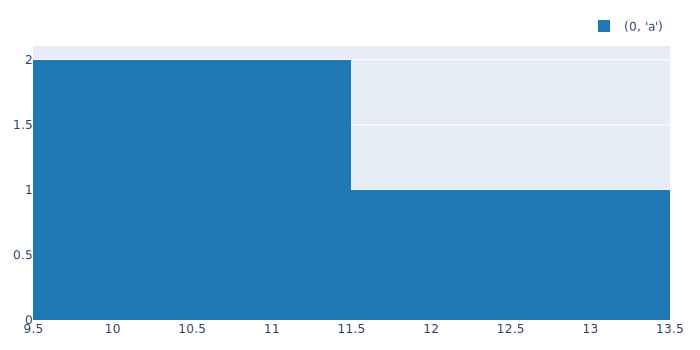

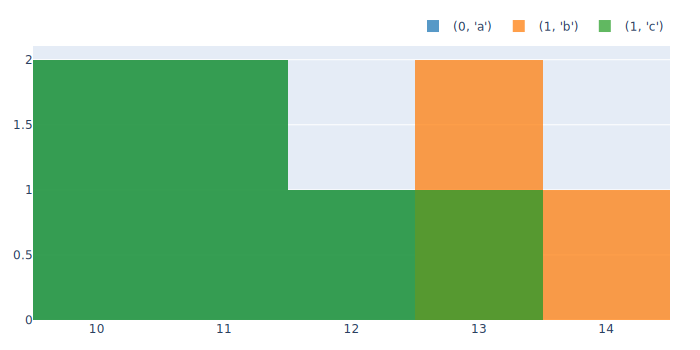

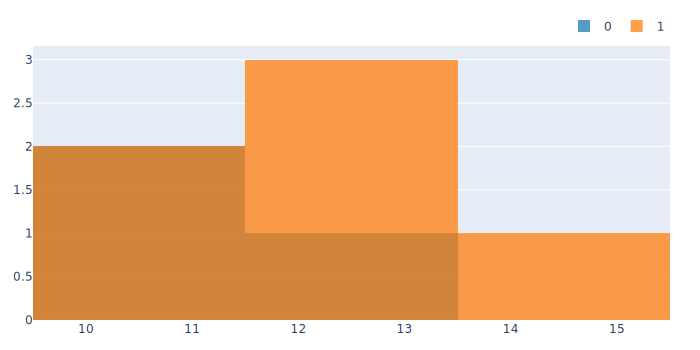

In [50]:
mapped_array[(0, 'a')].histplot().show_svg()
mapped_array.histplot().show_svg()
mapped_array_grouped.histplot().show_svg()

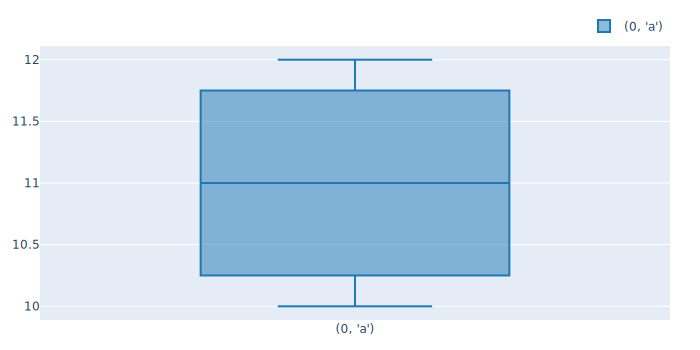

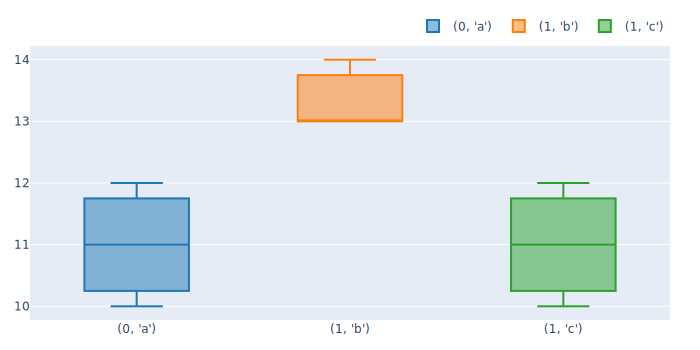

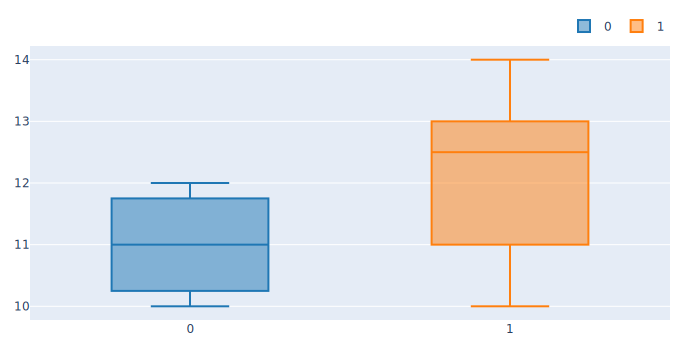

In [51]:
mapped_array[(0, 'a')].boxplot().show_svg()
mapped_array.boxplot().show_svg()
mapped_array_grouped.boxplot().show_svg()

## Records

In [52]:
print(records[(0, 'a')].values)
print(records[(0, 'a')].wrapper.columns)

print(records[(1, 'b')].values)
print(records[(1, 'b')].wrapper.columns)

print(records[[(0, 'a'), (0, 'a')]].values)
print(records[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records[[(0, 'a'), (1, 'b')]].values)
print(records[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records.iloc[0]
%timeit big_records.iloc[:]

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(3, 0, 0, 13., 18.) (4, 1, 0, 14., 17.) (5, 2, 0, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (0, 0, 1, 10., 21.) (1, 1, 1, 11., 20.) (2, 2, 1, 12., 19.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
810 µs ± 9.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.7 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
print(records_nosort[(0, 'a')].values)
print(records_nosort[(0, 'a')].wrapper.columns)

print(records_nosort[(1, 'b')].values)
print(records_nosort[(1, 'b')].wrapper.columns)

print(records_nosort[[(0, 'a'), (0, 'a')]].values)
print(records_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records_nosort[[(0, 'a'), (1, 'b')]].values)
print(records_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records_nosort.iloc[0]
%timeit big_records_nosort.iloc[:]

[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(5, 2, 0, 13., 18.) (4, 1, 0, 14., 17.) (3, 0, 0, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (2, 2, 1, 12., 19.) (1, 1, 1, 11., 20.) (0, 0, 1, 10., 21.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
842 µs ± 5.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.9 ms ± 678 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
print(records_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(records_grouped[0].wrapper.ndim)
print(records_grouped[0].wrapper.grouped_ndim)
print(records_grouped[0].wrapper.grouper.group_by)

print(records_grouped[1].wrapper.columns)
print(records_grouped[1].wrapper.ndim)
print(records_grouped[1].wrapper.grouped_ndim)
print(records_grouped[1].wrapper.grouper.group_by)

print(records_grouped[[0]].wrapper.columns)
print(records_grouped[[0]].wrapper.ndim)
print(records_grouped[[0]].wrapper.grouped_ndim)
print(records_grouped[[0]].wrapper.grouper.group_by)

print(records_grouped[[0, 1]].wrapper.columns)
print(records_grouped[[0, 1]].wrapper.ndim)
print(records_grouped[[0, 1]].wrapper.grouped_ndim)
print(records_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_records_grouped.iloc[0]
%timeit big_records_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
6.25 ms ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.9 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
print(records.wrapper.index)
print(records.wrapper.columns)
print(records.wrapper.ndim)
print(records.wrapper.grouper.group_by)

print(records_grouped.wrapper.index)
print(records_grouped.wrapper.columns)
print(records_grouped.wrapper.ndim)
print(records_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [56]:
print(records.values)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
3.54 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
print(records.records)

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
1   1    1    0         11.0         20.0
2   2    2    0         12.0         19.0
3   3    0    1         13.0         18.0
4   4    1    1         14.0         17.0
5   5    2    1         13.0         18.0
6   6    0    2         12.0         19.0
7   7    1    2         11.0         20.0
8   8    2    2         10.0         21.0


In [58]:
print(records.is_sorted())
%timeit big_records.is_sorted()

print(records_nosort.is_sorted())
%timeit big_records_nosort.is_sorted()

print(records.is_sorted(incl_id=True))
%timeit big_records.is_sorted(incl_id=True)

print(records_nosort.is_sorted(incl_id=True))
%timeit big_records_nosort.is_sorted(incl_id=True)

True
1.06 ms ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
8.89 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
1.56 ms ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
8.41 µs ± 37.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [59]:
print(records.sort().records_arr)
%timeit big_records.sort()

print(records_nosort.sort().records_arr)
%timeit big_records_nosort.sort()

print(records.sort(incl_id=True).records_arr)
%timeit big_records.sort(incl_id=True)

print(records_nosort.sort(incl_id=True).records_arr)
%timeit big_records_nosort.sort(incl_id=True)

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
1.3 ms ± 771 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)
 (8, 2, 2, 10., 21.) (7, 1, 2, 11., 20.) (6, 0, 2, 12., 19.)]
70.6 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
1.83 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
66 ms ± 1.53 ms per loop (mean ± std. dev. of 7 r

In [10]:
mask = records.values['some_field1'] >= records.values['some_field1'].mean()
print(records.apply_mask(mask).values)

big_mask = big_records.values['some_field1'] >= big_records.values['some_field1'].mean()
%timeit big_records.apply_mask(big_mask)

[(2, 2, 0, 12., 19.) (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.)
 (5, 2, 1, 13., 18.) (6, 0, 2, 12., 19.)]
10.4 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
@njit
def map_nb(record):
    return record.some_field1 + record.some_field2 * 2

print(records.map(map_nb).sum())
print(records_grouped.map(map_nb).sum())
print(records_grouped.map(map_nb, group_by=False).sum())

%timeit vbt.records.MappedArray(\
    big_wrapper,\
    big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2,\
    big_records_arr['col'],\
)
%timeit big_records.map(map_nb)  # faster

lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
lvl1
0    153.0
1    299.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
3.25 ms ± 735 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.53 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
print(records.map_field('col').values)
print(records.map_field('idx').values)
print(records.map_field('some_field1').values)
print(records.map_field('some_field2').values)

print(records.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1', group_by=False).sum())

%timeit big_records.map_field('some_field1')

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[21. 20. 19. 18. 17. 18. 19. 20. 21.]
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
lvl1
0    33.0
1    73.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
293 µs ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
print(records.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).values)
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).sum())
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2, group_by=False).sum())

%timeit big_records.map_array(big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2)

[52. 51. 50. 49. 48. 49. 50. 51. 52.]
lvl1
0    153.0
1    299.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
2.55 ms ± 544 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
print(records.count())
print(records_grouped.count())
print(records_grouped.count(group_by=False))

%timeit big_records.count()
%timeit big_records_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
lvl1
0    3
1    6
Name: count, dtype: int64
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
49.5 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
48.5 µs ± 595 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
filter_mask = np.array([True, False, False, False, False, False, False, False, True])

print(records.apply_mask(filter_mask).count())
print(records_grouped.apply_mask(filter_mask).count())
print(records_grouped.apply_mask(filter_mask, group_by=False).count())

lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
Name: count, dtype: int64
lvl1
0    1
1    1
Name: count, dtype: int64
lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
Name: count, dtype: int64


In [12]:
filtered_records = records.apply_mask(filter_mask)
print(filtered_records.records)

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
1   8    2    2         10.0         21.0


In [67]:
print(filtered_records[(0, 'a')].records)
print(filtered_records[(0, 'a')].map_field('some_field1').values)
print(filtered_records[(0, 'a')].map_field('some_field1').min())
print(filtered_records[(0, 'a')].count())

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
[10.]
10.0
1


In [68]:
print(filtered_records[(1, 'b')].records)
print(filtered_records[(1, 'b')].map_field('some_field1').values)
print(filtered_records[(1, 'b')].map_field('some_field1').min())
print(filtered_records[(1, 'b')].count())

Empty DataFrame
Columns: [id, idx, col, some_field1, some_field2]
Index: []
[]
nan
0


In [69]:
print(filtered_records[(1, 'c')].records)
print(filtered_records[(1, 'c')].map_field('some_field1').values)
print(filtered_records[(1, 'c')].map_field('some_field1').min())
print(filtered_records[(1, 'c')].count())

   id  idx  col  some_field1  some_field2
0   8    2    0         10.0         21.0
[10.]
10.0
1


In [70]:
print(filtered_records[(1, 'd')].records)
print(filtered_records[(1, 'd')].map_field('some_field1').values)
print(filtered_records[(1, 'd')].map_field('some_field1').min())
print(filtered_records[(1, 'd')].count())

Empty DataFrame
Columns: [id, idx, col, some_field1, some_field2]
Index: []
[]
nan
0


## Drawdowns

In [9]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}, index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6)
])

np.random.seed(42)
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)))

In [10]:
drawdowns = vbt.Drawdowns.from_ts(ts, freq='1 days')
print(drawdowns.values.shape)

(6,)


In [11]:
big_drawdowns = vbt.Drawdowns.from_ts(big_ts, freq='1 days')
print(big_drawdowns.values.shape)

(99845,)


In [74]:
%timeit vbt.Drawdowns.from_ts(big_ts, freq='1 days')

5.37 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

%timeit big_drawdowns.iloc[0]
%timeit big_drawdowns.iloc[:]

   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   0    0         0          1           1        2       2.0         1.0   
1   1    0         2          3           3        4       3.0         1.0   
2   2    0         4          5           5        5       4.0         1.0   
3   3    1         1          2           2        3       2.0         1.0   
4   4    1         3          4           4        5       3.0         1.0   
5   5    2         2          3           4        5       3.0         1.0   

   end_val  status  
0      2.0       1  
1      3.0       1  
2      1.0       0  
3      2.0       1  
4      3.0       1  
5      2.0       0  
            a  b  c  d
2020-01-01  2  1  1  1
2020-01-02  1  2  2  2
2020-01-03  3  1  3  3
2020-01-04  1  3  2  4
2020-01-05  4  1  1  5
2020-01-06  1  4  2  6
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   0    0         0          1           1        2       2.0     

In [76]:
print(drawdowns.records_readable)

   Drawdown Id Column Peak Timestamp Start Timestamp Valley Timestamp  \
0            0      a     2020-01-01      2020-01-02       2020-01-02   
1            1      a     2020-01-03      2020-01-04       2020-01-04   
2            2      a     2020-01-05      2020-01-06       2020-01-06   
3            3      b     2020-01-02      2020-01-03       2020-01-03   
4            4      b     2020-01-04      2020-01-05       2020-01-05   
5            5      c     2020-01-03      2020-01-04       2020-01-05   

  End Timestamp  Peak Value  Valley Value  End Value     Status  
0    2020-01-03         2.0           1.0        2.0  Recovered  
1    2020-01-05         3.0           1.0        3.0  Recovered  
2    2020-01-06         4.0           1.0        1.0     Active  
3    2020-01-04         2.0           1.0        2.0  Recovered  
4    2020-01-06         3.0           1.0        3.0  Recovered  
5    2020-01-06         3.0           1.0        2.0     Active  


In [77]:
print(drawdowns['a'].count())

print(drawdowns.count())
print(drawdowns.count(group_by=group_by))

3
a    3
b    2
c    1
d    0
Name: count, dtype: int64
group
first     5
second    1
Name: count, dtype: int64


In [80]:
print(drawdowns['a'].drawdown.to_pd())
print(drawdowns.drawdown.to_pd())

%timeit big_drawdowns.drawdown

2020-01-01         NaN
2020-01-02         NaN
2020-01-03   -0.500000
2020-01-04         NaN
2020-01-05   -0.666667
2020-01-06   -0.750000
Name: a, dtype: float64
                   a         b         c   d
2020-01-01       NaN       NaN       NaN NaN
2020-01-02       NaN       NaN       NaN NaN
2020-01-03 -0.500000       NaN       NaN NaN
2020-01-04       NaN -0.500000       NaN NaN
2020-01-05 -0.666667       NaN       NaN NaN
2020-01-06 -0.750000 -0.666667 -0.666667 NaN
463 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [81]:
print(drawdowns['a'].avg_drawdown())
print(drawdowns.avg_drawdown())
%timeit big_drawdowns.avg_drawdown()

print(drawdowns.avg_drawdown(group_by=group_by))
%timeit big_drawdowns.avg_drawdown(group_by=big_group_by)

-0.6388888888888888
a   -0.638889
b   -0.583333
c   -0.666667
d         NaN
Name: avg_drawdown, dtype: float64
1.12 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    -0.616667
second   -0.666667
Name: avg_drawdown, dtype: float64
4.65 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
print(drawdowns['a'].max_drawdown())
print(drawdowns.max_drawdown())
%timeit big_drawdowns.max_drawdown()

print(drawdowns.max_drawdown(group_by=group_by))
%timeit big_drawdowns.max_drawdown(group_by=big_group_by)

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d         NaN
Name: max_drawdown, dtype: float64
1.15 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    -0.750000
second   -0.666667
Name: max_drawdown, dtype: float64
3.81 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:
print(drawdowns['a'].recovery_return.to_pd())
print(drawdowns.recovery_return.to_pd())

%timeit big_drawdowns.recovery_return

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    2.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  2.0  NaN  NaN NaN
2020-01-06  0.0  2.0  1.0 NaN
479 µs ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
print(drawdowns['a'].avg_recovery_return())
print(drawdowns.avg_recovery_return())
%timeit big_drawdowns.avg_recovery_return()

print(drawdowns.avg_recovery_return(group_by=group_by))
%timeit big_drawdowns.avg_recovery_return(group_by=big_group_by)

1.0
a    1.0
b    1.5
c    1.0
d    NaN
Name: avg_recovery_return, dtype: float64
1.01 ms ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first     1.2
second    1.0
Name: avg_recovery_return, dtype: float64
3.48 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
print(drawdowns['a'].max_recovery_return())
print(drawdowns.max_recovery_return())
%timeit big_drawdowns.max_recovery_return()

print(drawdowns.max_recovery_return(group_by=group_by))
%timeit big_drawdowns.max_recovery_return(group_by=big_group_by)

2.0
a    2.0
b    2.0
c    1.0
d    NaN
Name: max_recovery_return, dtype: float64
1.06 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first     2.0
second    1.0
Name: max_recovery_return, dtype: float64
3.72 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
print(drawdowns['a'].duration.to_pd())
print(drawdowns.duration.to_pd())

%timeit big_drawdowns.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  3.0 NaN
483 µs ± 6.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [87]:
print(drawdowns['a'].avg_duration())
print(drawdowns.avg_duration())
%timeit big_drawdowns.avg_duration()

print(drawdowns.avg_duration(group_by=group_by))
%timeit big_drawdowns.avg_duration(group_by=big_group_by)

1 days 00:00:00
a   1 days
b   1 days
c   3 days
d      NaT
Name: avg_duration, dtype: timedelta64[ns]


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/array_wrapper.py:661: UserWarning:

Couldn't parse the frequency of index. Pass it as `freq` or define it globally under `settings.array_wrapper`.



905 µs ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    1 days
second   3 days
Name: avg_duration, dtype: timedelta64[ns]
3.34 ms ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
print(drawdowns['a'].max_duration())
print(drawdowns.max_duration())
%timeit big_drawdowns.max_duration()

print(drawdowns.max_duration(group_by=group_by))
%timeit big_drawdowns.max_duration(group_by=big_group_by)

1 days 00:00:00
a   1 days
b   1 days
c   3 days
d      NaT
Name: max_duration, dtype: timedelta64[ns]


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/array_wrapper.py:661: UserWarning:

Couldn't parse the frequency of index. Pass it as `freq` or define it globally under `settings.array_wrapper`.



992 µs ± 72.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    1 days
second   3 days
Name: max_duration, dtype: timedelta64[ns]
3.35 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
print(drawdowns['a'].coverage())
print(drawdowns.coverage())
%timeit big_drawdowns.coverage()

print(drawdowns.coverage(group_by=group_by))
%timeit big_drawdowns.coverage(group_by=big_group_by)

0.5
a    0.500000
b    0.333333
c    0.500000
d         NaN
Name: coverage, dtype: float64
13.8 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.416667
second    0.250000
Name: coverage, dtype: float64
16.8 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
print(drawdowns['a'].decline_duration.to_pd())
print(drawdowns.decline_duration.to_pd())

%timeit big_drawdowns.decline_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  2.0 NaN
518 µs ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [91]:
print(drawdowns['a'].recovery_duration.to_pd())
print(drawdowns.recovery_duration.to_pd())

%timeit big_drawdowns.recovery_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  0.0  1.0  1.0 NaN
479 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [92]:
print(drawdowns['a'].recovery_duration_ratio.to_pd())
print(drawdowns.recovery_duration_ratio.to_pd())

%timeit big_drawdowns.recovery_duration_ratio

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  0.0  1.0  0.5 NaN
699 µs ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
print(drawdowns.active)
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

%timeit big_drawdowns.active

Drawdowns(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa004833748> of shape (6, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa021f50870> of shape (2,)",
    "col_mapper": null,
    "ts": "<pandas.core.frame.DataFrame object at 0x7f9ff803f898> of shape (6, 4)",
    "freq": "1 days"
}))
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   2    0         4          5           5        5       4.0         1.0   

   end_val  status  
0      1.0       0  
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   2    0         4          5           5        5       4.0         1.0   

   end_val  status  
0      1.0       0  
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   2    0         4          5           5        5       4.0         1.0   
1   5    2         2          3           4        5       3.0         1.0   

   end_val  status  
0      1.0   

In [18]:
print(drawdowns.recovered)
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

%timeit big_drawdowns.recovered

Drawdowns(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa004833748> of shape (6, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa021f4bad8> of shape (4,)",
    "col_mapper": null,
    "ts": "<pandas.core.frame.DataFrame object at 0x7f9ff803f898> of shape (6, 4)",
    "freq": "1 days"
}))
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   0    0         0          1           1        2       2.0         1.0   
1   1    0         2          3           3        4       3.0         1.0   

   end_val  status  
0      2.0       1  
1      3.0       1  
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_val  \
0   0    0         0          1           1        2       2.0         1.0   
1   1    0         2          3           3        4       3.0         1.0   

   end_val  status  
0      2.0       1  
1      3.0       1  
   id  col  peak_idx  start_idx  valley_idx  end_idx  peak_val  valley_

In [95]:
print(drawdowns['a'].active_drawdown())
print(drawdowns.active_drawdown())

%timeit big_drawdowns.active_drawdown()

-0.75
a   -0.750000
b         NaN
c   -0.333333
d         NaN
Name: active_drawdown, dtype: float64
2.03 ms ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
print(drawdowns['a'].active_duration())
print(drawdowns.active_duration())

%timeit big_drawdowns.active_duration()

1 days 00:00:00
a   1 days
b      NaT
c   3 days
d      NaT
Name: active_duration, dtype: timedelta64[ns]


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/array_wrapper.py:661: UserWarning:

Couldn't parse the frequency of index. Pass it as `freq` or define it globally under `settings.array_wrapper`.



1.41 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [97]:
print(drawdowns['a'].active_recovery_return())
print(drawdowns.active_recovery_return())

%timeit big_drawdowns.active_recovery_return()

0.0
a    0.0
b    NaN
c    1.0
d    NaN
Name: active_recovery_return, dtype: float64
1.43 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [98]:
print(drawdowns['a'].active_recovery_duration())
print(drawdowns.active_recovery_duration())

%timeit big_drawdowns.active_recovery_duration()

0 days 00:00:00
a   0 days
b      NaT
c   1 days
d      NaT
Name: active_recovery_duration, dtype: timedelta64[ns]
1.41 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
print(drawdowns['a'].stats())
%timeit big_drawdowns[0].stats(silence_warnings=True)

print(drawdowns.stats(column='a'))
%timeit big_drawdowns.stats(column=0, silence_warnings=True)

print(drawdowns.stats())
%timeit big_drawdowns.stats(silence_warnings=True)

Start                          2020-01-01 00:00:00
End                            2020-01-06 00:00:00
Period                             6 days 00:00:00
Coverage [%]                                  50.0
Total Records                                    3
Total Recovered Drawdowns                        2
Total Active Drawdowns                           1
Active Drawdown [%]                           75.0
Active Duration                    1 days 00:00:00
Active Recovery [%]                            0.0
Active Recovery Return [%]                     0.0
Active Recovery Duration           0 days 00:00:00
Max Drawdown [%]                         66.666667
Avg Drawdown [%]                         58.333333
Max Drawdown Duration              1 days 00:00:00
Avg Drawdown Duration              1 days 00:00:00
Max Recovery Return [%]                      200.0
Avg Recovery Return [%]                      150.0
Max Recovery Duration              1 days 00:00:00
Avg Recovery Duration          

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7fa020856598>. Pass column to select a single column/group.
  import sys


45.2 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


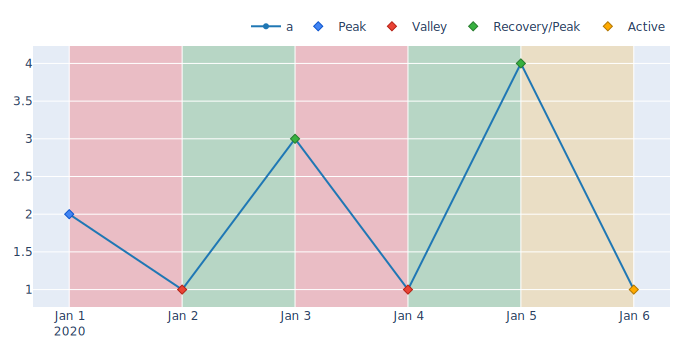

In [12]:
drawdowns['a'].plot().show_svg()

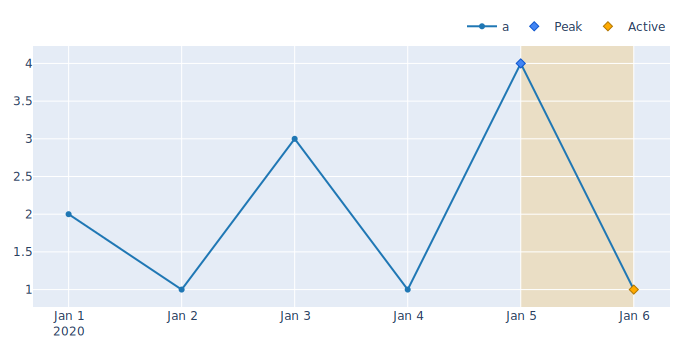

In [13]:
drawdowns.plot(column='a', top_n=1).show_svg()

## Orders

In [14]:
close = pd.Series([1, 2, 3, 4, 5, 6, 7, 8], index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
    datetime(2020, 1, 8)
]).vbt.tile(4, keys=['a', 'b', 'c', 'd'])
print(close)

big_close = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)))

            a  b  c  d
2020-01-01  1  1  1  1
2020-01-02  2  2  2  2
2020-01-03  3  3  3  3
2020-01-04  4  4  4  4
2020-01-05  5  5  5  5
2020-01-06  6  6  6  6
2020-01-07  7  7  7  7
2020-01-08  8  8  8  8


In [15]:
from vectorbt.portfolio.enums import order_dt

records_arr = np.asarray([
    (0, 0, 0, 1. , 1., 0.01 , 0), (1, 0, 1, 0.1, 2., 0.002, 0),
    (2, 0, 2, 1. , 3., 0.03 , 1), (3, 0, 3, 0.1, 4., 0.004, 1),
    (4, 0, 5, 1. , 6., 0.06 , 0), (5, 0, 6, 1. , 7., 0.07 , 1),
    (6, 0, 7, 2. , 8., 0.16 , 0), (7, 1, 0, 1. , 1., 0.01 , 1),
    (8, 1, 1, 0.1, 2., 0.002, 1), (9, 1, 2, 1. , 3., 0.03 , 0),
    (10, 1, 3, 0.1, 4., 0.004, 0), (11, 1, 5, 1. , 6., 0.06 , 1),
    (12, 1, 6, 1. , 7., 0.07 , 0), (13, 1, 7, 2. , 8., 0.16 , 1),
    (14, 2, 0, 1. , 1., 0.01 , 0), (15, 2, 1, 0.1, 2., 0.002, 0),
    (16, 2, 2, 1. , 3., 0.03 , 1), (17, 2, 3, 0.1, 4., 0.004, 1),
    (18, 2, 5, 1. , 6., 0.06 , 0), (19, 2, 6, 2. , 7., 0.14 , 1),
    (20, 2, 7, 2. , 8., 0.16 , 0)
], dtype=order_dt)
print(records_arr.shape)

wrapper = vbt.ArrayWrapper.from_obj(close, freq='1 days')
orders = vbt.Orders(wrapper, records_arr, close)
orders_grouped = vbt.Orders(wrapper.regroup(group_by), records_arr, close)

(21,)


In [16]:
big_records_arr = np.asarray(list(zip(*(
    np.arange(1000000),
    np.tile(np.arange(1000), 1000),
    np.repeat(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)

big_wrapper = vbt.ArrayWrapper.from_obj(big_close, freq='1 days')
big_orders = vbt.Orders(big_wrapper, big_records_arr, big_close)
big_orders_grouped = vbt.Orders(big_wrapper.copy(group_by=big_group_by), big_records_arr, big_close)

(1000000,)


In [106]:
print(orders.records)
print(orders.close)

print(orders['a'].records)
print(orders['a'].close)

%timeit big_orders.iloc[0]
%timeit big_orders.iloc[:]

%timeit big_orders_grouped.iloc[0]
%timeit big_orders_grouped.iloc[:]

    id  col  idx  size  price   fees  side
0    0    0    0   1.0    1.0  0.010     0
1    1    0    1   0.1    2.0  0.002     0
2    2    0    2   1.0    3.0  0.030     1
3    3    0    3   0.1    4.0  0.004     1
4    4    0    5   1.0    6.0  0.060     0
5    5    0    6   1.0    7.0  0.070     1
6    6    0    7   2.0    8.0  0.160     0
7    7    1    0   1.0    1.0  0.010     1
8    8    1    1   0.1    2.0  0.002     1
9    9    1    2   1.0    3.0  0.030     0
10  10    1    3   0.1    4.0  0.004     0
11  11    1    5   1.0    6.0  0.060     1
12  12    1    6   1.0    7.0  0.070     0
13  13    1    7   2.0    8.0  0.160     1
14  14    2    0   1.0    1.0  0.010     0
15  15    2    1   0.1    2.0  0.002     0
16  16    2    2   1.0    3.0  0.030     1
17  17    2    3   0.1    4.0  0.004     1
18  18    2    5   1.0    6.0  0.060     0
19  19    2    6   2.0    7.0  0.140     1
20  20    2    7   2.0    8.0  0.160     0
            a  b  c  d
2020-01-01  1  1  1  1
2020-01-

In [107]:
print(orders.records_readable)

    Order Id Column  Timestamp  Size  Price   Fees  Side
0          0      a 2020-01-01   1.0    1.0  0.010   Buy
1          1      a 2020-01-02   0.1    2.0  0.002   Buy
2          2      a 2020-01-03   1.0    3.0  0.030  Sell
3          3      a 2020-01-04   0.1    4.0  0.004  Sell
4          4      a 2020-01-06   1.0    6.0  0.060   Buy
5          5      a 2020-01-07   1.0    7.0  0.070  Sell
6          6      a 2020-01-08   2.0    8.0  0.160   Buy
7          7      b 2020-01-01   1.0    1.0  0.010  Sell
8          8      b 2020-01-02   0.1    2.0  0.002  Sell
9          9      b 2020-01-03   1.0    3.0  0.030   Buy
10        10      b 2020-01-04   0.1    4.0  0.004   Buy
11        11      b 2020-01-06   1.0    6.0  0.060  Sell
12        12      b 2020-01-07   1.0    7.0  0.070   Buy
13        13      b 2020-01-08   2.0    8.0  0.160  Sell
14        14      c 2020-01-01   1.0    1.0  0.010   Buy
15        15      c 2020-01-02   0.1    2.0  0.002   Buy
16        16      c 2020-01-03 

In [23]:
print(orders.buy)
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

%timeit big_orders.buy

Orders(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f780709d0> of shape (11,)",
    "col_mapper": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  idx  size  price   fees  side
0   0    0    0   1.0    1.0  0.010     0
1   1    0    1   0.1    2.0  0.002     0
2   4    0    5   1.0    6.0  0.060     0
3   6    0    7   2.0    8.0  0.160     0
   id  col  idx  size  price   fees  side
0   0    0    0   1.0    1.0  0.010     0
1   1    0    1   0.1    2.0  0.002     0
2   4    0    5   1.0    6.0  0.060     0
3   6    0    7   2.0    8.0  0.160     0
    id  col  idx  size  price   fees  side
0    0    0    0   1.0    1.0  0.010     0
1    1    0    1   0.1    2.0  0.002     0
2    4    0    5   1.0    6.0  0.060     0
3    6    0    7   2.0    8.0  0.160     0
4    9    1    2   1.0    3.0  0.030     0
5   10    

In [24]:
print(orders.sell)
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

%timeit big_orders.sell

Orders(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa0223c06b8> of shape (10,)",
    "col_mapper": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  idx  size  price   fees  side
0   2    0    2   1.0    3.0  0.030     1
1   3    0    3   0.1    4.0  0.004     1
2   5    0    6   1.0    7.0  0.070     1
   id  col  idx  size  price   fees  side
0   2    0    2   1.0    3.0  0.030     1
1   3    0    3   0.1    4.0  0.004     1
2   5    0    6   1.0    7.0  0.070     1
   id  col  idx  size  price   fees  side
0   2    0    2   1.0    3.0  0.030     1
1   3    0    3   0.1    4.0  0.004     1
2   5    0    6   1.0    7.0  0.070     1
3   7    1    0   1.0    1.0  0.010     1
4   8    1    1   0.1    2.0  0.002     1
5  11    1    5   1.0    6.0  0.060     1
6  13    1    7   2.0    8.0  0.160     1
7  16    2    2 

In [25]:
print(orders['a'].stats())
%timeit big_orders[0].stats(silence_warnings=True)

print(orders.stats(column='a'))
%timeit big_orders.stats(column=0, silence_warnings=True)

print(orders.stats())
%timeit big_orders.stats(silence_warnings=True)

Start                2020-01-01 00:00:00
End                  2020-01-08 00:00:00
Period                   8 days 00:00:00
Total Records                          7
Total Buy Orders                       4
Total Sell Orders                      3
Min Size                             0.1
Max Size                             2.0
Avg Size                        0.885714
Avg Buy Size                       1.025
Avg Sell Size                        0.7
Avg Buy Price                       4.25
Avg Sell Price                  4.666667
Total Fees                         0.336
Min Fees                           0.002
Max Fees                            0.16
Avg Fees                           0.048
Avg Buy Fees                       0.058
Avg Sell Fees                   0.034667
Name: a, dtype: object
14 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Start                2020-01-01 00:00:00
End                  2020-01-08 00:00:00
Period                   8 days 00:00:00
Total 

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7fa020856598>. Pass column to select a single column/group.
  import sys


84.7 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


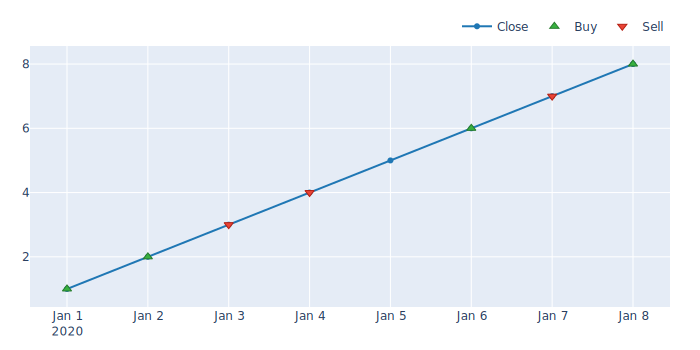

In [27]:
orders['a'].plot().show_svg()

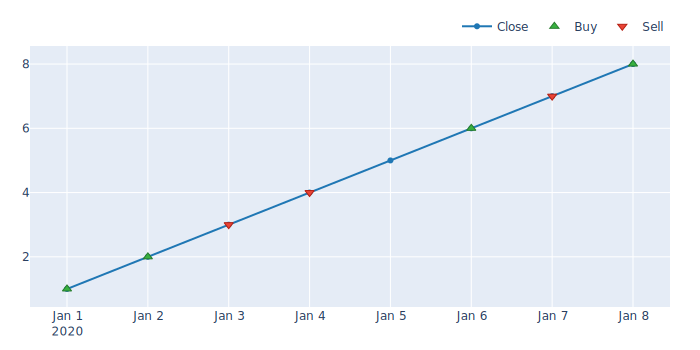

In [28]:
orders.plot(column='a').show_svg()

## Trades

In [20]:
trades = vbt.ExitTrades.from_orders(orders)
trades_grouped = vbt.ExitTrades.from_orders(orders_grouped)
print(trades.values.shape)

(13,)


In [21]:
big_trades = vbt.ExitTrades.from_orders(big_orders)
big_trades_grouped = vbt.ExitTrades.from_orders(big_orders_grouped)
print(big_trades.values.shape)

(1000,)


In [22]:
%timeit vbt.ExitTrades.from_orders(big_orders)

4.55 ms ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(trades.records)
print(trades.close)

print(trades['a'].records)
print(trades['a'].close)

%timeit big_trades.iloc[0]
%timeit big_trades.iloc[:]

%timeit big_trades_grouped.iloc[0]
%timeit big_trades_grouped.iloc[:]

    id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0    0   1.0          0     1.090909    0.010909         2         3.0   
1    1    0   0.1          0     1.090909    0.001091         3         4.0   
2    2    0   1.0          5     6.000000    0.060000         6         7.0   
3    3    0   2.0          7     8.000000    0.160000         7         8.0   
4    4    1   1.0          0     1.090909    0.010909         2         3.0   
5    5    1   0.1          0     1.090909    0.001091         3         4.0   
6    6    1   1.0          5     6.000000    0.060000         6         7.0   
7    7    1   2.0          7     8.000000    0.160000         7         8.0   
8    8    2   1.0          0     1.090909    0.010909         2         3.0   
9    9    2   0.1          0     1.090909    0.001091         3         4.0   
10  10    2   1.0          5     6.000000    0.060000         6         7.0   
11  11    2   1.0          6     7.000000    0.07000

In [33]:
print(trades.records_readable)

    Trade Id Column  Size Entry Timestamp  Avg Entry Price  Entry Fees  \
0          0      a   1.0      2020-01-01         1.090909    0.010909   
1          1      a   0.1      2020-01-01         1.090909    0.001091   
2          2      a   1.0      2020-01-06         6.000000    0.060000   
3          3      a   2.0      2020-01-08         8.000000    0.160000   
4          4      b   1.0      2020-01-01         1.090909    0.010909   
5          5      b   0.1      2020-01-01         1.090909    0.001091   
6          6      b   1.0      2020-01-06         6.000000    0.060000   
7          7      b   2.0      2020-01-08         8.000000    0.160000   
8          8      c   1.0      2020-01-01         1.090909    0.010909   
9          9      c   0.1      2020-01-01         1.090909    0.001091   
10        10      c   1.0      2020-01-06         6.000000    0.060000   
11        11      c   1.0      2020-01-07         7.000000    0.070000   
12        12      c   1.0      2020-01

In [34]:
print(trades['a'].count())
print(trades.count())
%timeit big_trades.count()

print(trades_grouped.count())
%timeit big_trades_grouped.count()

4
a    4
b    4
c    5
d    0
Name: count, dtype: int64
49.4 µs ± 504 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
group
first     8
second    5
Name: count, dtype: int64
49 µs ± 303 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
print(trades.winning)
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

%timeit big_trades.winning

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f7cf155b0> of shape (6,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0      

In [36]:
print(trades.losing)
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

%timeit big_trades.losing

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa007ca3a28> of shape (7,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7     8.000

In [39]:
print(trades['a'].winning_streak.to_pd(ignore_index=True))
print(trades.winning_streak.to_pd(ignore_index=True))

%timeit big_trades.winning_streak

0    1
1    2
2    3
3    0
Name: a, dtype: int64
     a    b    c   d
0  1.0  0.0  1.0 NaN
1  2.0  0.0  2.0 NaN
2  3.0  0.0  3.0 NaN
3  0.0  0.0  0.0 NaN
4  NaN  NaN  0.0 NaN
565 µs ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
print(trades['a'].losing_streak.to_pd(ignore_index=True))
print(trades.losing_streak.to_pd(ignore_index=True))

%timeit big_trades.losing_streak

0    0
1    0
2    0
3    1
Name: a, dtype: int64
     a    b    c   d
0  0.0  1.0  0.0 NaN
1  0.0  2.0  0.0 NaN
2  0.0  3.0  0.0 NaN
3  1.0  4.0  1.0 NaN
4  NaN  NaN  2.0 NaN
551 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
print(trades['a'].win_rate())
print(trades.win_rate())
%timeit big_trades.win_rate()

print(trades.win_rate(group_by=group_by))
%timeit big_trades.win_rate(group_by=big_group_by)

0.75
a    0.75
b    0.00
c    0.60
d     NaN
Name: win_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide



951 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first     0.375
second    0.600
Name: win_rate, dtype: float64
5.47 ms ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(trades['a'].profit_factor())
print(trades.profit_factor())
%timeit big_trades.profit_factor()

print(trades_grouped.profit_factor())
%timeit big_trades_grouped.profit_factor()

18.9
a    18.900000
b     0.000000
c     2.458537
d          NaN
Name: profit_factor, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

divide by zero encountered in true_divide



2.65 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.818182
second    2.458537
Name: profit_factor, dtype: float64
2.57 ms ± 65.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(trades['a'].expectancy())
print(trades.expectancy())
%timeit big_trades.expectancy()

print(trades_grouped.expectancy())
%timeit big_trades_grouped.expectancy()

0.716
a    0.7160
b   -0.8840
c    0.3588
d       NaN
Name: expectancy, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide



3.55 ms ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.0840
second    0.3588
Name: expectancy, dtype: float64
3.54 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(trades['a'].sqn())
print(trades.sqn())
%timeit big_trades.sqn()

print(trades_grouped.sqn())
%timeit big_trades_grouped.sqn()

1.634155521947584
a    1.634156
b   -2.130073
c    0.716604
d         NaN
Name: sqn, dtype: float64
1.32 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    -0.204047
second    0.716604
Name: sqn, dtype: float64
924 µs ± 9.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
print(trades.long)
print(trades['a'].long.records)
print(trades.long['a'].records)
print(trades.long.records)

%timeit big_trades.long

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f68734be0> of shape (8,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   
3   3    0   2.0          7     8.000000    0.160000         7         8.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
3      0.000 -0.160000

In [46]:
print(trades.short)
print(trades['a'].short.records)
print(trades.short['a'].records)
print(trades.short.records)

%timeit big_trades.short

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f7a2d8608> of shape (5,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
Empty DataFrame
Columns: [id, col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_id]
Index: []
Empty DataFrame
Columns: [id, col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_id]
Index: []
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   4    1   1.0          0     1.090909    0.010909         2         3.0   
1   5    1   0.1          0     1.090909    0.001091         3         4.0   
2   6    1   1.0          5     6.000000    0.060000         6         7.0   
3   7    1   2.0          7    

In [47]:
print(trades.open)
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

%timeit big_trades.open

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f7cd48978> of shape (3,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          

In [48]:
print(trades.closed)
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

%timeit big_trades.closed

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7f9f78606d30> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9f7a4e3608> of shape (10,)",
    "col_mapper": null,
    "ts": null,
    "close": "<pandas.core.frame.DataFrame object at 0x7f9f782a4390> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0     

In [49]:
print(trades['a'].stats())
%timeit big_trades[0].stats(silence_warnings=True)

print(trades.stats(column='a'))
%timeit big_trades.stats(column=0, silence_warnings=True)

print(trades.stats())
%timeit big_trades.stats(silence_warnings=True)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

divide by zero encountered in true_divide



Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Coverage                          5 days 00:00:00
Overlap Coverage                  2 days 00:00:00
Total Records                                   4
Total Long Trades                               4
Total Short Trades                              0
Total Closed Trades                             3
Total Open Trades                               1
Open Trade PnL                              -0.16
Win Rate [%]                                100.0
Max Win Streak                                  3
Max Loss Streak                                 0
Best Trade [%]                              262.0
Worst Trade [%]                              14.5
Avg Winning Trade [%]                      149.25
Avg Losing Trade [%]                          NaN


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

invalid value encountered in true_divide



42.1 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Coverage                          5 days 00:00:00
Overlap Coverage                  2 days 00:00:00
Total Records                                   4
Total Long Trades                               4
Total Short Trades                              0
Total Closed Trades                             3
Total Open Trades                               1
Open Trade PnL                              -0.16
Win Rate [%]                                100.0
Max Win Streak                                  3
Max Loss Streak                                 0
Best Trade [%]                              262.0
Worst Trade [%]                              14.5
Avg Winning Trade [%]          

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

divide by zero encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

invalid value encountered in true_divide



44.4 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Coverage                          5 days 08:00:00
Overlap Coverage                  2 days 00:00:00
Total Records                                3.25
Total Long Trades                             2.0
Total Short Trades                           1.25
Total Closed Trades                           2.5
Total Open Trades                            0.75
Open Trade PnL                               -0.1
Win Rate [%]                            58.333333
Max Win Streak                                2.0
Max Loss Streak                          1.333333
Best Trade [%]                         168.388889
Worst Trade [%]                        -91.087302
Avg Winning Trade [%]        

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:530: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

divide by zero encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:544: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x7fa020856598>. Pass column to select a single column/group.



44.9 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


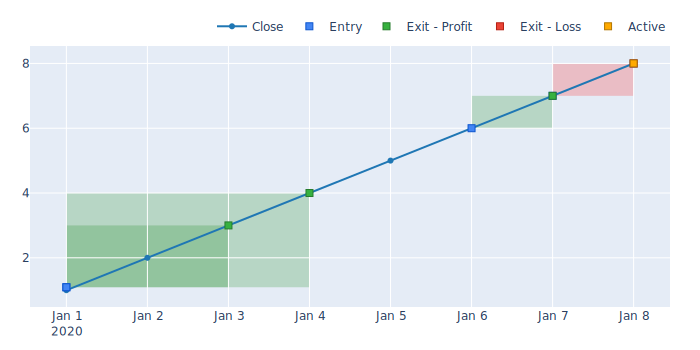

In [26]:
trades['c'].plot().show_svg()

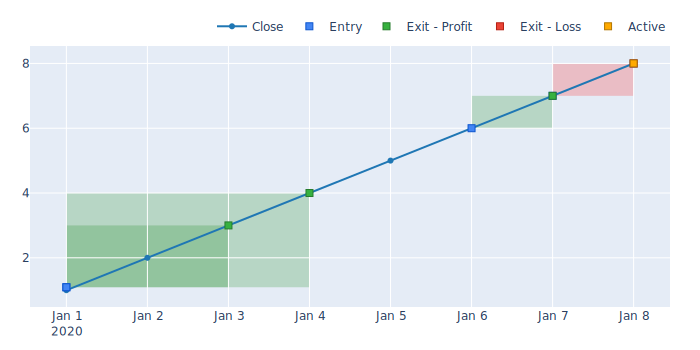

In [28]:
trades.plot(column='c').show_svg()

## Positions

In [29]:
positions = vbt.Positions.from_trades(trades)
positions_grouped = vbt.Positions.from_trades(trades_grouped)
print(positions.values.shape)

(10,)


In [30]:
big_positions = vbt.Positions.from_trades(big_trades)
big_positions_grouped = vbt.Positions.from_trades(big_trades_grouped)
print(big_positions.values.shape)

(1000,)


In [31]:
%timeit vbt.Positions.from_trades(big_trades)

724 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
print(positions.records)
print(positions.close)

print(positions['a'].records)
print(positions['a'].close)

%timeit big_positions.iloc[0]
%timeit big_positions.iloc[:]

%timeit big_positions_grouped.iloc[0]
%timeit big_positions_grouped.iloc[:]

   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.1          0     1.090909       0.012         3    3.090909   
1   1    0   1.0          5     6.000000       0.060         6    7.000000   
2   2    0   2.0          7     8.000000       0.160         7    8.000000   
3   3    1   1.1          0     1.090909       0.012         3    3.090909   
4   4    1   1.0          5     6.000000       0.060         6    7.000000   
5   5    1   2.0          7     8.000000       0.160         7    8.000000   
6   6    2   1.1          0     1.090909       0.012         3    3.090909   
7   7    2   1.0          5     6.000000       0.060         6    7.000000   
8   8    2   1.0          6     7.000000       0.070         7    8.000000   
9   9    2   1.0          7     8.000000       0.080         7    8.000000   

   exit_fees    pnl    return  direction  status  
0      0.034  2.154  1.795000          0       1  
1      0.070  0.870  0.145000          

In [32]:
print(positions['a'].stats())
%timeit big_positions[0].stats(silence_warnings=True)

print(positions.stats(column='a'))
%timeit big_positions.stats(column=0, silence_warnings=True)

print(positions.stats())
%timeit big_positions.stats(silence_warnings=True)

Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Coverage                          5 days 00:00:00
Overlap Coverage                  0 days 00:00:00
Total Records                                   3
Total Long Trades                               3
Total Short Trades                              0
Total Closed Trades                             2
Total Open Trades                               1
Open Trade PnL                              -0.16
Win Rate [%]                                100.0
Max Win Streak                                  2
Max Loss Streak                                 0
Best Trade [%]                              179.5
Worst Trade [%]                              14.5
Avg Winning Trade [%]                        97.0
Avg Losing Trade [%]                          NaN


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x7fd11874c598>. Pass column to select a single column/group.



45.5 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
